# Human Life Expectancy Prediction - Modeling using Regressors

###                                                           Karthick Ganesan KXG170003 
###                                                           Sruthi Yammanuru SXY190008

# We have got this data set from Kaggle
https://www.kaggle.com/ncsaayali/life-expectancy

The data set conists of Human Life Expectancy per country and their status, and other human life statistics such as BMI, Mortality rate, Disease affliction etc. The data set also gives information on the nation's GDP, total expenditure on disease control and population. Our aim is to predict Life expectancy of each and every country over the number of years and see which model perfoms best on this data set

## Reading Data and setting up all the imports

In [71]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from IPython.core.interactiveshell import InteractiveShell
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df=pd.read_csv("Life Expectancy Data.csv")

## Stripping all columns of their extra spaces 

In [4]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [5]:
df.columns = df.columns.str.strip()
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

## Converting the BMI attribute from numerical to Ordinal values.

We are converting in such a way in order to capture the effect of BMI on Life expectancy clearly. Being numerical, the model may sometimes fail to capture the relationship of values which are on the border between any two BMI categories. Converting this feature into Ordinal works better as it will be easy for the model to distinguish the numbers into categories. The accuracy will be increased. 

In [6]:
mask = (df['BMI'] < 18.5)  
df['Majority BMI'] = np.nan
df['Majority BMI'][mask] = 'Under Weight'

mask = (df['BMI'] >= 18.5) & (df['BMI'] < 25)
df['Majority BMI'][mask] = 'Normal Weight'

mask = (df['BMI'] >= 25) & (df['BMI'] < 30)  
df['Majority BMI'][mask] = 'Over Weight'

mask = (df['BMI'] >= 30)   
df['Majority BMI'][mask] = 'Obese'

In [7]:
df = df.drop(['BMI'], axis=1)

In [8]:
df['Majority BMI'].unique()

array(['Normal Weight', 'Under Weight', 'Obese', 'Over Weight', nan],
      dtype=object)

## Reviewing the features and its data types 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null float64
GDP                                2490 non-null

## Introducing missing values randomly so that I get to handle them later

In [11]:
(df.isna().sum().sum()/np.product(df.shape))*100

3.965282505105514

In [12]:
df=df.mask(np.random.random(df.shape)<0.040)

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Country,Country,3.607897
Year,Year,3.539823
Status,Status,3.437713
Life expectancy,Life expectancy,3.948264
Adult Mortality,Adult Mortality,4.628999
infant deaths,infant deaths,3.744044
Alcohol,Alcohol,9.768550
percentage expenditure,percentage expenditure,3.063308
Hepatitis B,Hepatitis B,22.498298
Measles,Measles,4.390742


In [13]:
(df.isna().sum().sum()/np.product(df.shape))*100

7.676836437898385

## Data Imputation 

In [14]:
cv=df.loc[:, df.select_dtypes(include='object').columns].columns
cv

Index(['Country', 'Status', 'Majority BMI'], dtype='object')

In [15]:
for i in cv:
    df[i].fillna(df[i].mode()[0],inplace=True)
for i in df.select_dtypes(include=['float64','int64','int32']).columns:
    df[i].fillna(df[i].mean(),inplace=True)

In [16]:
(df.isna().sum().sum()/np.product(df.shape))*100

0.0

In [17]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Majority BMI'],
      dtype='object')

In [18]:
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Majority BMI
0,Afghanistan,2015.000000,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,83.000000,6.000000,8.16,65.0,0.100000,584.259210,33736494.0,17.2,17.300000,0.479,10.1,Normal Weight
1,Afghanistan,2014.000000,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,41.314225,58.000000,8.18,62.0,0.100000,7558.307621,327582.0,17.5,17.500000,0.476,10.0,Normal Weight
2,Afghanistan,2007.511644,Developing,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,89.000000,62.000000,8.13,64.0,0.100000,631.744976,31731688.0,17.7,17.700000,0.470,9.9,Under Weight
3,Afghanistan,2012.000000,Developing,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,93.000000,67.000000,8.52,67.0,0.100000,669.959000,3696958.0,17.9,18.000000,0.463,9.8,Under Weight
4,Afghanistan,2011.000000,Developing,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,97.000000,68.000000,7.87,68.0,0.100000,63.537231,2978599.0,18.2,4.863711,0.454,9.5,Under Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004.000000,Developing,44.3,723.0,27.0,4.36,0.000000,68.0,31.0,42.000000,67.000000,7.13,65.0,33.600000,454.366654,12777511.0,9.4,9.400000,0.407,9.2,Over Weight
2934,Zimbabwe,2003.000000,Developing,44.5,715.0,26.0,4.06,0.000000,7.0,998.0,41.000000,82.643748,6.52,68.0,36.700000,453.351155,12633897.0,9.8,9.900000,0.418,9.5,Over Weight
2935,Algeria,2002.000000,Developing,44.8,73.0,25.0,4.43,0.000000,73.0,304.0,40.000000,73.000000,6.53,71.0,39.800000,57.348340,125525.0,1.2,1.300000,0.427,10.0,Over Weight
2936,Zimbabwe,2001.000000,Developing,45.3,686.0,25.0,1.72,0.000000,76.0,529.0,39.000000,76.000000,6.16,75.0,42.100000,548.587312,12366165.0,1.6,1.700000,0.427,9.8,Over Weight


## Creating dummy variables to perform One-Hot Encoding

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cat = df.select_dtypes('object')
num = df.select_dtypes(numerics)
cat_dummies = pd.get_dummies(cat)
cat_dummies

,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,Country_Bahamas,Country_Bahrain,Country_Bangladesh,Country_Barbados,Country_Belarus,Country_Belgium,Country_Belize,Country_Benin,Country_Bhutan,Country_Bolivia (Plurinational State of),Country_Bosnia and Herzegovina,Country_Botswana,Country_Brazil,Country_Brunei Darussalam,Country_Bulgaria,Country_Burkina Faso,Country_Burundi,Country_Cabo Verde,Country_Cambodia,Country_Cameroon,Country_Canada,Country_Central African Republic,Country_Chad,Country_Chile,Country_China,Country_Colombia,Country_Comoros,Country_Congo,Country_Cook Islands,Country_Costa Rica,Country_Croatia,Country_Cuba,Country_Cyprus,Country_Czechia,Country_Côte d'Ivoire,Country_Democratic People's Republic of Korea,Country_Democratic Republic of the Congo,Country_Denmark,Country_Djibouti,Country_Dominica,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_El Salvador,Country_Equatorial Guinea,Country_Eritrea,Country_Estonia,Country_Ethiopia,Country_Fiji,Country_Finland,Country_France,Country_Gabon,Country_Gambia,Country_Georgia,Country_Germany,Country_Ghana,Country_Greece,Country_Grenada,Country_Guatemala,Country_Guinea,Country_Guinea-Bissau,Country_Guyana,Country_Haiti,Country_Honduras,Country_Hungary,Country_Iceland,Country_India,Country_Indonesia,Country_Iran (Islamic Republic of),Country_Iraq,Country_Ireland,Country_Israel,Country_Italy,Country_Jamaica,Country_Japan,Country_Jordan,Country_Kazakhstan,Country_Kenya,Country_Kiribati,Country_Kuwait,Country_Kyrgyzstan,Country_Lao People's Democratic Republic,Country_Latvia,Country_Lebanon,Country_Lesotho,Country_Liberia,Country_Libya,Country_Lithuania,Country_Luxembourg,Country_Madagascar,Country_Malawi,Country_Malaysia,Country_Maldives,Country_Mali,Country_Malta,Country_Marshall Islands,Country_Mauritania,Country_Mauritius,Country_Mexico,Country_Micronesia (Federated States of),Country_Monaco,Country_Mongolia,Country_Montenegro,Country_Morocco,Country_Mozambique,Country_Myanmar,Country_Namibia,Country_Nauru,Country_Nepal,Country_Netherlands,Country_New Zealand,Country_Nicaragua,Country_Niger,Country_Nigeria,Country_Niue,Country_Norway,Country_Oman,Country_Pakistan,Country_Palau,Country_Panama,Country_Papua New Guinea,Country_Paraguay,Country_Peru,Country_Philippines,Country_Poland,Country_Portugal,Country_Qatar,Country_Republic of Korea,Country_Republic of Moldova,Country_Romania,Country_Russian Federation,Country_Rwanda,Country_Saint Kitts and Nevis,Country_Saint Lucia,Country_Saint Vincent and the Grenadines,Country_Samoa,Country_San Marino,Country_Sao Tome and Principe,Country_Saudi Arabia,Country_Senegal,Country_Serbia,Country_Seychelles,Country_Sierra Leone,Country_Singapore,Country_Slovakia,Country_Slovenia,Country_Solomon Islands,Country_Somalia,Country_South Africa,Country_South Sudan,Country_Spain,Country_Sri Lanka,Country_Sudan,Country_Suriname,Country_Swaziland,Country_Sweden,Country_Switzerland,Country_Syrian Arab Republic,Country_Tajikistan,Country_Thailand,Country_The former Yugoslav republic of Macedonia,Country_Timor-Leste,Country_Togo,Country_Tonga,Country_Trinidad and Tobago,Country_Tunisia,Country_Turkey,Country_Turkmenistan,Country_Tuvalu,Country_Uganda,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom of Great Britain and Northern Ireland,Country_United Republic of Tanzania,Country_United States of America,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe,Status_Developed,Status_Developing,Majority BMI_Normal Weight,Majority BMI_Obese,Majority BMI_Over Weight,Majority BMI_Under Weight
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [20]:
LE=pd.concat([num,cat_dummies],axis=1)
LE

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaijan,Country_Bahamas,Country_Bahrain,Country_Bangladesh,Country_Barbados,Country_Belarus,Country_Belgium,Country_Belize,Country_Benin,Country_Bhutan,Country_Bolivia (Plurinational State of),Country_Bosnia and Herzegovina,Country_Botswana,Country_Brazil,Country_Brunei Darussalam,Country_Bulgaria,Country_Burkina Faso,Country_Burundi,Country_Cabo Verde,Country_Cambodia,Country_Cameroon,Country_Canada,Country_Central African Republic,Country_Chad,Country_Chile,Country_China,Country_Colombia,Country_Comoros,Country_Congo,Country_Cook Islands,Country_Costa Rica,Country_Croatia,Country_Cuba,Country_Cyprus,Country_Czechia,Country_Côte d'Ivoire,Country_Democratic People's Republic of Korea,Country_Democratic Republic of the Congo,Country_Denmark,Country_Djibouti,Country_Dominica,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_El Salvador,Country_Equatorial Guinea,Country_Eritrea,Country_Estonia,Country_Ethiopia,Country_Fiji,Country_Finland,Country_France,Country_Gabon,Country_Gambia,Country_Georgia,Country_Germany,Country_Ghana,Country_Greece,Country_Grenada,Country_Guatemala,Country_Guinea,Country_Guinea-Bissau,Country_Guyana,Country_Haiti,Country_Honduras,Country_Hungary,Country_Iceland,Country_India,Country_Indonesia,Country_Iran (Islamic Republic of),Country_Iraq,Country_Ireland,Country_Israel,Country_Italy,Country_Jamaica,Country_Japan,Country_Jordan,Country_Kazakhstan,Country_Kenya,Country_Kiribati,Country_Kuwait,Country_Kyrgyzstan,Country_Lao People's Democratic Republic,Country_Latvia,Country_Lebanon,Country_Lesotho,Country_Liberia,Country_Libya,Country_Lithuania,Country_Luxembourg,Country_Madagascar,Country_Malawi,Country_Malaysia,Country_Maldives,Country_Mali,Country_Malta,Country_Marshall Islands,Country_Mauritania,Country_Mauritius,Country_Mexico,Country_Micronesia (Federated States of),Country_Monaco,Country_Mongolia,Country_Montenegro,Country_Morocco,Country_Mozambique,Country_Myanmar,Country_Namibia,Country_Nauru,Country_Nepal,Country_Netherlands,Country_New Zealand,Country_Nicaragua,Country_Niger,Country_Nigeria,Country_Niue,Country_Norway,Country_Oman,Country_Pakistan,Country_Palau,Country_Panama,Country_Papua New Guinea,Country_Paraguay,Country_Peru,Country_Philippines,Country_Poland,Country_Portugal,Country_Qatar,Country_Republic of Korea,Country_Republic of Moldova,Country_Romania,Country_Russian Federation,Country_Rwanda,Country_Saint Kitts and Nevis,Country_Saint Lucia,Country_Saint Vincent and the Grenadines,Country_Samoa,Country_San Marino,Country_Sao Tome and Principe,Country_Saudi Arabia,Country_Senegal,Country_Serbia,Country_Seychelles,Country_Sierra Leone,Country_Singapore,Country_Slovakia,Country_Slovenia,Country_Solomon Islands,Country_Somalia,Country_South Africa,Country_South Sudan,Country_Spain,Country_Sri Lanka,Country_Sudan,Country_Suriname,Country_Swaziland,Country_Sweden,Country_Switzerland,Country_Syrian Arab Republic,Country_Tajikistan,Country_Thailand,Country_The former Yugoslav republic of Macedonia,Country_Timor-Leste,Country_Togo,Country_Tonga,Country_Trinidad and Tobago,Country_Tunisia,Country_Turkey,Country_Turkmenistan,Country_Tuvalu,Country_Uganda,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom of Great Britain and Northern Ireland,Country_United Republic of Tanzania,Country_United States of America,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela (Bolivarian Republic of),Country_Viet Nam,Country_Yemen,Country_Zambia,Country_Zimbabwe,Status_Developed,Status_Developing,Majority BMI_Normal Weight,Majority 

## Train Test Split & Data Scaling using Standard Scaler

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.metrics import accuracy_score , confusion_matrix 
from sklearn.svm import SVC
import time

In [22]:
# defining feature matrix(X) and response vector(y) 
y = LE["Life expectancy"]
X = LE.drop('Life expectancy', axis=1)  


# splitting X and y into training and testing sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling using multiple regression models, hyper parameter tuning using gridsearch, evaluation using cross validation

## KNN Regressor 

We can see that the model performs really well with this data set. The best parameters are manhattan metric, distance and neighbor value is 3. 

The model performs really well on the training and yields a good test score

In [23]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':np.arange(start=3, stop=25, step=3),
               'weights' : ['uniform','distance'],
                'metric' : ['euclidean','manhattan']}
grid = GridSearchCV(KNeighborsRegressor(),
                    grid_params,
                    cv=3,
                    n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([ 3,  6,  9, 12, 15, 18, 21, 24]), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)

Best Params {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Score 0.9081680617916335


In [31]:
KNN = KNeighborsRegressor(n_neighbors=3, metric='manhattan', weights='distance')
KNN.fit(X_train,y_train)

print("KNN Regressor Train Score",KNN.score(X_train,y_train))
print("KNN Regressor Test Score",KNN.score(X_test,y_test))


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='distance')

KNN Regressor Train Score 1.0
KNN Regressor Test Score 0.89915157905926


## Simple Linear Regression 

The simple linear model performs well but not as good as KNN regressor. 

In [44]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 


lreg = LinearRegression()

lreg.fit(X_train, y_train)
print("Simple Linear Regressor Train Score", lreg.score(X_train, y_train))
print("Simple Linear Regression Test Score", lreg.score(X_test, y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Simple Linear Regressor Train Score 0.9231574711153442
Simple Linear Regression Test Score 0.8832933280736636


## Ridge 

I have tried scaling both Standard Sclaing and Min Max Scaling. Ridge didnot perform well with Standard Scaled data but performs satisfactory with the MinMax Scaled data.
Ridge performs well but not as good as KNN 

In [45]:
# defining feature matrix(X) and response vector(y) 
y = LE["Life expectancy"]
X = LE.drop('Life expectancy', axis=1)  

In [46]:
# splitting X and y into training and testing sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
#Using MinMax Scaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 

scaler = MinMaxScaler()
X_trainMinMax = scaler.fit_transform(X_train)
X_testMinMax = scaler.transform(X_test)

In [53]:
from  sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, solver = ['lsqr', 'sag']), cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
#print(grid)
# summarize the results of the grid search
print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)
print("Best Estimator for Alpha",grid.best_estimator_.alpha)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00]), 'solver': ['lsqr', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Params {'alpha': 1.0, 'solver': 'sag'}
Best Score -0.0071243429935740595
Best Estimator for Alpha 1.0


In [50]:
from  sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, solver = ['lsqr', 'sag']), cv=5, n_jobs=-1)
grid.fit(X_trainMinMax, y_train)
#print(grid)
# summarize the results of the grid search
print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)
print("Best Estimator for Alpha",grid.best_estimator_.alpha)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00]), 'solver': ['lsqr', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Params {'alpha': 0.1, 'solver': 'sag'}
Best Score 0.9033677207406231
Best Estimator for Alpha 0.1


In [54]:
ridge = Ridge(alpha=1.0, solver = 'sag')
ridge.fit(X_train,y_train)
print("Train Score with Standard scaled data",ridge.score(X_train,y_train))
print("Test Score with Standard scaled data",ridge.score(X_test,y_test))
ridge = Ridge(alpha=0.1, solver = 'sag')
ridge.fit(X_trainMinMax,y_train)
print("Ridge Train Score with MinMax scaled data",ridge.score(X_trainMinMax,y_train))
print("Ridge Test Score with MinMax scaled data",ridge.score(X_testMinMax,y_test))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='sag', tol=0.001)

Train Score with Standard scaled data 0.0004018218258690087
Test Score with Standard scaled data 0.000639007592613039


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='sag', tol=0.001)

Ridge Train Score with MinMax scaled data 0.9230446335518762
Ridge Test Score with MinMax scaled data 0.8833493187381795


## Lasso 

Lasso performs similarly to that of Ridge. 

In [55]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

In [59]:
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, selection = ['random','cyclic']), cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# summarize the results of the grid search
print("Best Score", grid.best_score_)
print("Best Params", grid.best_params_)
print("Best Estimator for Alpha",grid.best_estimator_.alpha)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00]), 'selection': ['random', 'cyclic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Score 0.9030982622832515
Best Params {'alpha': 0.0, 'selection': 'random'}
Best Estimator for Alpha 0.0


In [60]:
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, selection = ['random', 'cyclic']), cv=5, n_jobs=-1)
grid.fit(X_trainMinMax, y_train)

# summarize the results of the grid search
print("Best Score", grid.best_score_)
print("Best Params", grid.best_params_)
print("Best Estimator for Alpha",grid.best_estimator_.alpha)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00]), 'selection': ['random', 'cyclic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Score 0.9030852848965073
Best Params {'alpha': 0.0, 'selection': 'cyclic'}
Best Estimator for Alpha 0.0


In [61]:
lasso = Lasso(alpha=0.0, selection='random')
lasso.fit(X_train,y_train)
print("Lasso Train Score with Standard scaled data",lasso.score(X_train,y_train))
print("Lasso Test Score with Standard scaled data",lasso.score(X_test,y_test))
lasso = Lasso(alpha=0.0,selection='cyclic')
lasso.fit(X_trainMinMax,y_train)
print("Lasso Train Score with MinMax scaled data",lasso.score(X_trainMinMax,y_train))
print("Lasso Test Score with MinMax scaled data",lasso.score(X_testMinMax,y_test))

Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False)

Lasso Train Score with Standard scaled data 0.9231574711153471
Lasso Test Score with Standard scaled data 0.8833040271564129


Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso Train Score with MinMax scaled data 0.9231574711153472
Lasso Test Score with MinMax scaled data 0.8832865214132197


## Polynomial Regressor


Polynomial regressor doesn't do well on this data compared to the previous models. 

Trains well but doesn't perform on the test data set

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 
from  sklearn.preprocessing  import PolynomialFeatures

In [69]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lreg.fit(X_train_poly, y_train)
print("Ploynomial regressor train score: ",lreg.score(X_train_poly, y_train))
print("Ploynomial regressor train score: ",lreg.score(X_test_poly, y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Ploynomial regressor train score:  0.9094516694588479
Ploynomial regressor train score:  0.5461696940584467


## Simple SVM Regression

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

In [73]:
svr = LinearSVR()

grid = GridSearchCV(estimator=svr, param_grid=dict(C=[0.01,0.1,1,10], epsilon=[0.01,0.1,1,10]), cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

# summarize the results of the grid search
print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'epsilon': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Params {'C': 10, 'epsilon': 1}
Best Score 0.7572515024137234


In [75]:
from sklearn.svm import SVR
regressor=LinearSVR(C=10,epsilon=1)
regressor.fit(X_train,y_train)

print("LinearSVR train score:",regressor.score(X_train,y_train))
print("LinearSVR test score:",regressor.score(X_test,y_test))

LinearSVR(C=10, dual=True, epsilon=1, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

LinearSVR train score: 0.91095538014054
LinearSVR test score: 0.8737790043282194


## SVM Regressor - Linear

SVM regressor with linear kernel. The best value for C is 0.1. The model does good with train and test with almost equal performance

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [81]:
svr = SVR(kernel='linear')
grid = GridSearchCV(estimator=svr, param_grid=dict(C=[0.01,0.1,1,10]), cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

# summarize the results of the grid search
print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

Best Params {'C': 0.1}
Best Score 0.9016043528640489


In [82]:
regressor=SVR(kernel='linear', C=0.1)
regressor.fit(X_train,y_train)

print("SVR Linear Kernel train score:",regressor.score(X_train,y_train))
print("SVR Linear Kernel train score:",regressor.score(X_test,y_test))

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

SVR Linear Kernel train score: 0.912676623938363
SVR Linear Kernel train score: 0.8765679741495925


## SVM Regressor with RBF Kernel 

This model with RBF kernel performs better than the linear kernel.

In [ ]:
parameters = { 'C':[0.01,0.1,1,10],'gamma': [0.01,0.1,1,10]}

svr=SVR(kernel='rbf')

grid = GridSearchCV(svr, parameters, cv= 5, n_jobs=-1)
grid.fit(X_train,y_train)

print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)

In [85]:
regressor=SVR(kernel='rbf', gamma=0.01,C=10)
regressor.fit(X_train,y_train)

print("SVR RBF Kernel train score:", regressor.score(X_train,y_train))
print("SVR RBF Kernel train score:", regressor.score(X_test,y_test))

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR RBF Kernel train score: 0.9554028214154358
SVR RBF Kernel train score: 0.8916366454447593


## SVM Regressor with Poly Kernel  

SVM Regressor with Poly Kernel degree performs better than SVM with Rbf Kernel

In [86]:
parameters = { 'C':[0.01,0.1,1,10], 'degree': [2,3], 'gamma': [0.01,0.1,1,10]}

svr=SVR(kernel='poly')

grid = GridSearchCV(svr, parameters, cv= 3, n_jobs=-1)
grid.fit(X_train,y_train)

print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'degree': [2, 3], 'gamma': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Params {'C': 10, 'degree': 3, 'gamma': 0.01}
Best Score 0.8993380435766509


In [88]:
from sklearn.svm import SVR
regressor=SVR(kernel='poly', degree=3, gamma=0.01,C=10)
regressor.fit(X_train,y_train)

print("SVR Poly Kernel train score:", regressor.score(X_train,y_train))
print("SVR Poly Kernel train score:", regressor.score(X_test,y_test))

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR Poly Kernel train score: 0.9629542735998006
SVR Poly Kernel train score: 0.8926496575310551


# Decision Tree Regressor 

The criterions friedman_mse, max depth of 14 and min sample split of 9 and random splitter are the best parameters.

The model performs well on these parameters

In [89]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1) 

In [90]:
parameters = {'criterion':['mse', 'friedman_mse', 'mae'],
              'splitter':['best','random'],
              'max_depth':[8,10,14,None],
              'min_samples_split':[2,3,5,7,9,11,13],
              'max_features':['auto','sqrt','log2']
             }

Dtree=DecisionTreeRegressor()
grid = GridSearchCV(Dtree, parameters, cv= 5, n_jobs=-1)

grid.fit(X_train,y_train)

print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['mse', 'friedman_mse', 'mae'], 'splitter': ['best', 'random'], 'max_depth': [8, 10, 14, None], 'min_samples_split': [2, 3, 5, 7, 9, 11, 13], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Params {'criterion': 'friedman_mse', 'max_depth': 14, 'max_features': 'auto', 'min_samples_split': 9, 'splitter': 'random'}
Best Score 0.863583972888148


In [95]:
regressor = DecisionTreeRegressor(criterion = 'friedman_mse',
                                  max_depth=14,
                                  min_samples_split=9,
                                  splitter='random')
regressor.fit(X_train, y_train)

print("Decision Tree Regressor Score:", regressor.score(X_train,y_train))
print("Decision Tree Regressor Score:", regressor.score(X_test,y_test))

# predict on all data
#pred_tree = tree.predict(X_test)
#pred_tree_train = tree.predict(X_train)

# undo log-transform
#y_predicted = np.exp(pred_tree)
#price_tree_train = np.exp(pred_tree_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=9,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='random')

Decision Tree Regressor Score: 0.9566145208806474
Decision Tree Regressor Score: 0.8561191752186142


## RandomForest Regressor

On an average the estimate is off only by 1.59 degrees.

This is a very good score and proves that Random Forest model is accurate than any other model we have applied so far. 

We got a test score of 90.9% and accuracy of 97.63%

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [113]:
parameters = {'n_estimators':[1400,1600,1800],
              'random_state':[60,80,90],              
              'max_depth':[12,14,16]
             }

rf=RandomForestRegressor()
grid = GridSearchCV(rf, parameters, cv= 3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid.fit(X_train,y_train)

print("Best Params", grid.best_params_)
print("Best Score", grid.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 10.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1400, 1600, 1800], 'random_state': [60, 80, 90], 'max_depth': [12, 14, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

Best Params {'max_depth': 16, 'n_estimators': 1600, 'random_state': 80}
Best Score -7.662775960285841


In [114]:
rf = RandomForestRegressor(max_depth=16, n_estimators = 1600, random_state = 80)
rf.fit(X_train, y_train)

print("Random Forest Regressor Train Score:", rf.score(X_train,y_train))
print("Random Forest Regressor Test Score:", rf.score(X_test,y_test))

feature_names=X.columns
#predictions = rf.predict(X_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=None,
           oob_score=False, random_state=80, verbose=0, warm_start=False)

Random Forest Regressor Train Score: 0.9885222556865935
Random Forest Regressor Test Score: 0.9089046065104556


In [115]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
scores

array([-1.63951147, -1.73532435, -1.60130524, -1.59272794, -1.55912166,
       -1.66454259, -1.81894126, -1.63479315, -1.55282827, -1.63846952])

In [270]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
predictions
# Calculate the absolute errors
errors = abs(predictions - y_test)

array([82.35782541, 56.95243666, 65.12888997, 67.70947824, 47.475625  ,
       81.9321484 , 68.23874184, 71.95498259, 72.42552449, 77.56664933,
       74.16924744, 82.19584952, 52.9038322 , 57.75123312, 72.88290945,
       59.76871786, 75.44151434, 71.57532004, 60.96937426, 53.16428394,
       72.40611467, 73.68703016, 69.7370064 , 56.65667061, 80.90845006,
       80.45141483, 74.24896934, 68.08996301, 69.01078147, 54.49761217,
       69.9101399 , 54.18652147, 73.38355782, 73.33989711, 79.10492396,
       74.21624335, 68.45595325, 79.25332613, 73.83995052, 72.69183503,
       74.04036739, 81.41126159, 72.49250009, 60.03156127, 68.19828617,
       73.02928988, 62.90108903, 69.245958  , 73.65330147, 52.72704553,
       47.78695485, 73.18504802, 72.11202963, 47.16910445, 71.09873366,
       71.7208528 , 65.33997103, 72.56077458, 62.36011531, 67.37404325,
       53.96153535, 47.7732558 , 59.8307338 , 68.6200016 , 73.7611397 ,
       73.73543605, 72.34239633, 54.44917736, 78.28174406, 65.59

Mean Absolute Error: 1.59 degrees.
RMSE 2.7250074479346154
Mean squared error  7.42566559129913


In [271]:
# Print out the mean absolute error (mae), rmse
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mse=np.mean((y_test-predictions)**2)
print("RMSE", np.sqrt(mse))

Mean Absolute Error: 1.59 degrees.
RMSE 2.7250074479346154


In [267]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
print("Mean Absolute percentage error", np.mean(mape))
print("Prediction Accuracy", 100 - np.mean(mape))

Mean Absolute percentage error 2.368133039281745
Prediction Accuracy 97.63186696071826


In [259]:
print("R2 Score: ", r2_score(y_test,predictions))

R2 Score:  0.9089046065104556


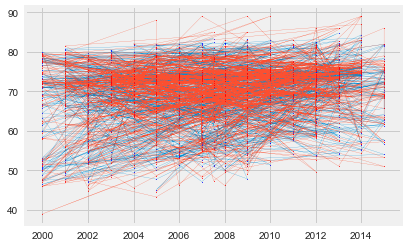

In [272]:
plt.plot(X_test['Year'],predictions, marker='o', markerfacecolor='blue', markersize=1,  linewidth=0.2)
plt.plot(X_test['Year'], y_test, marker='o', markerfacecolor='red', markersize=1, linewidth=0.2)

In [224]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

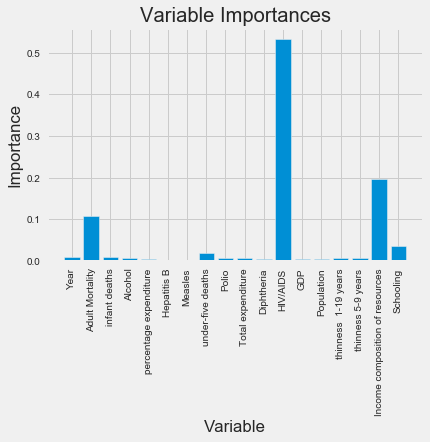

In [223]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances[0:18])))
# Make a bar chart
plt.bar(x_values, importances[0:18], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_names[0:18], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


## Results & Findings 

### For the Human Life Expectancy data set, the best model to predict the expectancy factor values most accurately is "Random Forest Regressor"

#### Accuracy:  97.63
#### Train Score: 0.98
#### Test Score: 0.91
#### MAPE: 2.63%  Prediction Accuracy: 97.63%
#### R2 Score: 0.91
#### RMSE: 2.72

#### It was a great learning experience, having the chance to apply all regression models on this data set. 
#### The fun part was tuning the hyper parameters using Grid Search where I understood how the change in parameters affects the performance of a model. I also enjoyed exploring the data and preparing it for the modeling. 
#### All regressors performed reasonably and in the end the best performance was given by Random Forest.
#### The model generalized well to the data and prevented over fitting and discovered complex dependencies. 